# Clustering

## Load libraries

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from scipy.special import expit
from typing import List, Dict
import time
import cProfile
import pstats
import io
import category_encoders as ce
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import copy
from torch_geometric.transforms import RandomNodeSplit
from collections import Counter
from category_encoders import BinaryEncoder
import cProfile
import pstats
import io



# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.1
Pandas version: 2.0.3
Matplotlib version: 3.7.1
Scikit-learn version: 1.3.0
Torch version: 2.0.1+cu117
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA RTX A6000 (cuda)
CUDA version: 11.7
Number of CUDA devices: 2


## Load data

In [2]:
dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'finemapped': 'int64',
    'causal': 'int64',
    'trait': 'string'
}

data = pd.read_csv('gwas-fine-causal.csv', dtype=dtypes)

# Assert column names
expected_columns = ['#chrom', 'pos', 'ref', 'alt', 'rsids', 'nearest_genes', 'pval', 'mlogp', 'beta',
                    'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls', 'finemapped',
                    'id', 'causal', 'trait']
assert set(data.columns) == set(expected_columns), "Unexpected columns in the data DataFrame."

# Assert data types
expected_dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'finemapped': 'int64',
    'causal': 'int64',
    'trait': 'string'
}

for col, expected_dtype in expected_dtypes.items():
    assert data[col].dtype == expected_dtype, f"Unexpected data type for column {col}."

In [3]:
# Check for total number of null values in each column
null_counts = data.isnull().sum()

print("Total number of null values in each column:")
print(null_counts)

Total number of null values in each column:
#chrom                   0
pos                      0
ref                      0
alt                      0
rsids              1366396
nearest_genes       727855
pval                     0
mlogp                    0
beta                     0
sebeta                   0
af_alt                   0
af_alt_cases             0
af_alt_controls          0
id                       0
finemapped               0
causal                   0
trait                    0
dtype: int64


## Data manipulation

In [4]:
data = data.sample(frac=0.1, random_state=42)
len(data)

1008500

### Find nearest gene

In [5]:
data['nearest_genes'] = data['nearest_genes'].astype(str)

# Assert column 'nearest_genes' is a string
assert data['nearest_genes'].dtype == 'object', "Column 'nearest_genes' is not of string type."

# Get the length of the data before transformation
original_length = len(data)

# Extract the first gene name from the 'nearest_genes' column
data['nearest_genes'] = data['nearest_genes'].str.split(',').str[0]

# Reset index to have a standard index
data = data.reset_index(drop=True)

# Assert the length of the data remains the same
assert len(data) == original_length, "Length of the data has changed after transformation."

## Spec

### Data

`data` Pandas DataFrame:

- `id`: This column represents the id of the variant in the following format: #chrom:pos:ref:alt (string).
- `#chrom`: This column represents the chromosome number where the genetic variant is located (int).
- `pos`: This is the position of the genetic variant on the chromosome (int: 1-200,000).
- `ref`: This column represents the reference allele (or variant) at the genomic position.
- `alt`: This is the alternate allele observed at this position.
- `rsids`: This stands for reference SNP cluster ID. It's a unique identifier for each variant used in the dbSNP database.
- `nearest_genes`: This column represents the gene which is nearest to the variant (string).
- `pval`: This represents the p-value, which is a statistical measure for the strength of evidence against the null hypothesis.
- `mlogp`: This represents the minus log of the p-value, commonly used in genomic studies.
- `beta`: The beta coefficient represents the effect size of the variant.
- `sebeta`: This is the standard error of the beta coefficient.
- `af_alt`: This is the allele frequency of the alternate variant in the general population (float: 0-1.
- `af_alt_cases`: This is the allele frequency of the alternate variant in the cases group (float: 0-1).
- `af_alt_controls`: This is the allele frequency of the alternate variant in the control group (float: 0-1).
- `finemapped`: This column represents whether the variant is included in the post-finemapped dataset (1) or not (0) (int).
- `trait`: This column represents the trait associated with the variant. In this dataset, it is the response to the drug paracetamol and NSAIDs.


### Nodes and Their Features

There is one type of node: SNP nodes.

- **SNP Nodes**: Each SNP Node is characterized by various features, including `id`, `nearest_genes`, `#chrom`, `pos`, `ref`, `alt`, `mlogp`, `beta`, `sebeta`,  `af_alt`, `af_alt_cases`, and `af_alt_controls` columns.

### Edges, Their Features, and Labels

Edges represent relationships between SNP nodes in the graph:

- For each pair of SNPs (row1 and row2) that exist on the same chromosome (`#chrom`), an edge is created if the absolute difference between their positions (`pos`) is less than or equal to 1,000,000 and greater than 1 (no loops). Create edges between all pairs of SNPs within the 1,000,000 base distance threshold. The edge weight is determined by the following formula:
     
```
weights = 1 * e^(-ln(2) / 100_000 * pos_diff_abs)
```

## pyg graph creation

In [6]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from sklearn.preprocessing import RobustScaler
import cProfile, pstats, io
from scipy.spatial import distance

## Graph stats

## PyTorch Geometric -> NetworkX

## nx graph creation

In [7]:
import pandas as pd
import numpy as np
import math
import networkx as nx
from scipy.spatial import distance

In [8]:
%%time

def create_graph(data):
    # Sort the data
    data.sort_values(['#chrom', 'pos'], inplace=True)
    
    # Create the graph
    G = nx.Graph()

    # Add nodes to the graph in bulk using a dict comprehension
    G.add_nodes_from({
        row['id']: row.to_dict() 
        for _, row in data.iterrows()
    })

    # Define a function to calculate weights for given indices
    def calculate_weights(pos_diffs):
        mask = (pos_diffs > 1) & (pos_diffs <= 300_000)
        indices = np.argwhere(mask)
        unique_indices = indices[indices[:, 0] < indices[:, 1]]
        unique_pos_diffs = pos_diffs[unique_indices[:, 0], unique_indices[:, 1]]
        return unique_indices, 1 * np.exp(-np.log(2) / 100_000 * unique_pos_diffs)

    # Iterate over each chromosome group
    for chrom, group in data.groupby('#chrom'):
        ids = group['id'].values
        pos = group['pos'].values
        
        # Apply batch operation
        chunk_size = 40_000
        overlap = 2_500  # Define overlap size
        num_chunks = math.ceil(len(pos) / chunk_size)
        
        for chunk in range(num_chunks):
            start_idx = max(0, chunk * chunk_size - overlap)
            end_idx = min((chunk + 1) * chunk_size + overlap, len(pos))
            
            # Calculate pairwise absolute differences in position within each chunk
            chunk_pos = pos[start_idx:end_idx]
            chunk_pos_diffs = distance.squareform(distance.pdist(chunk_pos[:, None], 'cityblock'))

            # Calculate weights
            unique_indices, unique_weights = calculate_weights(chunk_pos_diffs)

            # Add the unique edges to the graph with weights
            for (i, j), weight in zip(unique_indices, unique_weights):
                node1 = ids[start_idx + i]
                node2 = ids[start_idx + j]
                if not G.has_edge(node1, node2):
                    G.add_edge(node1, node2, weight=weight)

        del ids, pos  # Delete to free memory
        group = None  # Free memory

    return G


nx_graph = create_graph(data)


CPU times: total: 9min 45s
Wall time: 9min 48s


In [9]:
# Print basic graph statistics
print("Number of nodes:", nx_graph.number_of_nodes())
print("Number of edges:", nx_graph.number_of_edges())

# Print number of connected components
num_components = nx.number_connected_components(nx_graph)
print("Number of connected components:", num_components)

from collections import Counter

# Get degree distribution
degree_sequence = sorted([d for n, d in nx_graph.degree()], reverse=True)
degree_counts = Counter(degree_sequence)

# Print degree distribution statistics
print("Degree distribution statistics:")
print("Minimum degree:", min(degree_counts.keys()))
print("Maximum degree:", max(degree_counts.keys()))
print("Average degree:", sum(degree_counts.keys()) / len(degree_counts.keys()))

# Get the edge weight data
edge_weights = [data['weight'] for _, _, data in nx_graph.edges(data=True) if 'weight' in data]

# Convert edge weights to floats
edge_weights = [float(weight) for weight in edge_weights if weight != 'weight']

# Print edge weight statistics
print("Edge weight statistics:")
print("Minimum weight:", min(edge_weights))
print("Maximum weight:", max(edge_weights))
print("Average weight:", np.mean(edge_weights))
print("Standard deviation of weights:", np.std(edge_weights))


# Find the largest connected component
largest_component = max(nx.connected_components(nx_graph), key=len)

# Get the subgraph of the largest connected component
largest_component_subgraph = nx_graph.subgraph(largest_component)

# Print the size of the largest connected component
print("Size of the largest connected component (nodes):", largest_component_subgraph.number_of_nodes())
print("Size of the largest connected component (edges):", largest_component_subgraph.number_of_edges())


Number of nodes: 1008500
Number of edges: 111296573
Number of connected components: 85
Degree distribution statistics:
Minimum degree: 0
Maximum degree: 677
Average degree: 337.56804733727813
Edge weight statistics:
Minimum weight: 0.12500000000000003
Maximum weight: 0.999986137152479
Average weight: 0.42388542614449043
Standard deviation of weights: 0.24565196618911167
Size of the largest connected component (nodes): 50365
Size of the largest connected component (edges): 5190684


In [ ]:
import pickle

with open('nx_graph.pkl', 'wb') as f:
    pickle.dump(nx_graph, f)

#with open('nx_graph.pkl', 'rb') as f:
#    nx_graph = pickle.load(f)

## Clustering

### Louvain Algorithm

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import operator
from community import community_louvain
import matplotlib.cm as cm
import seaborn as sns


In [11]:
# Detect communities using Louvain method
partition = community_louvain.best_partition(nx_graph, weight='weight')

# Print number of communities
print(f"Number of communities: {len(set(partition.values()))}")



Number of communities: 303


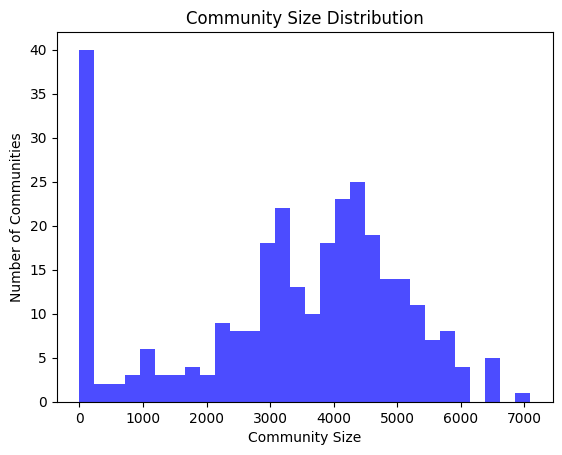

In [12]:
communities = set(partition.values())
community_sizes = [list(partition.values()).count(x) for x in communities]

plt.hist(community_sizes, bins=30, color='blue', alpha=0.7)
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.show()

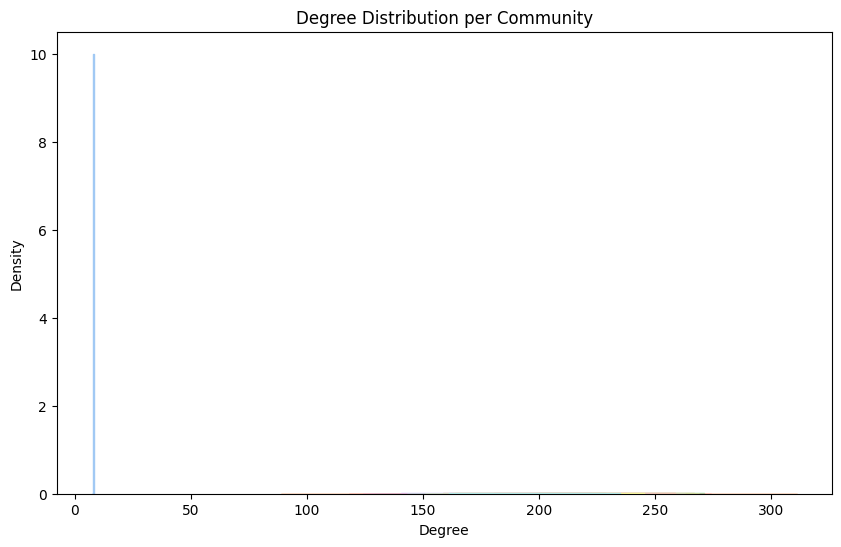

In [17]:
communities = defaultdict(list)

for node, community in partition.items():
    communities[community].append(node)
plt.figure(figsize=(10,6))
colors = sns.color_palette('pastel')[0:len(communities)]

for (community, nodes), color in zip(communities.items(), colors):
    degrees = [nx_graph.degree(n) for n in nodes]
    sns.histplot(degrees, bins=10, kde=False, color=color, element="step", stat="density")

plt.title('Degree Distribution per Community')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.show()


In [ ]:
# 2. Centrality measures per community
# Calculating centrality measures for large graphs can be computationally expensive.
# Therefore, you might want to select a subset of communities or nodes for this analysis.
for community, nodes in list(communities.items())[:5]:  # Just the first 5 communities
    subgraph = nx_graph.subgraph(nodes)
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)

    print(f'Community {community}:')
    print(f'Max degree centrality: {max(degree_centrality.items(), key=operator.itemgetter(1))}')
    print(f'Max betweenness centrality: {max(betweenness_centrality.items(), key=operator.itemgetter(1))}')
    print(f'Max closeness centrality: {max(closeness_centrality.items(), key=operator.itemgetter(1))}')
    print('\n')

In [14]:
# 3. Community interconnectivity
intra_edges = 0
inter_edges = 0
for u, v in nx_graph.edges():
    if partition[u] == partition[v]:
        intra_edges += 1
    else:
        inter_edges += 1

print(f'Ratio of intra-community to inter-community edges: {intra_edges / inter_edges}')

Ratio of intra-community to inter-community edges: 200.85497008355566


In [24]:
communities = defaultdict(list)

for node, community in partition.items():
    communities[community].append(node)
    
# 4. Community contribution to overall network structure
community_edge_weights = dict()
for community, nodes in communities.items():
    subgraph = nx_graph.subgraph(nodes)
    total_edge_weight = sum([data.get('weight', 1) for u, v, data in subgraph.edges(data=True)])
    community_edge_weights[community] = total_edge_weight

# Convert dictionary to DataFrame for better visualization and sort by the edge weight
df = pd.DataFrame(list(community_edge_weights.items()), columns=['Community', 'Sum of edge weights'])
df = df.sort_values('Sum of edge weights', ascending=False)
df

,Community,Sum of edge weights
136,145,374312.608724
243,254,370862.276273
88,94,347078.140740
235,246,344579.044419
268,281,339240.300157
...,...,...
276,289,0.000000
225,236,0.000000
125,132,0.000000
271,284,0.000000


In [25]:
# Create a dictionary for storing the chromosome and min and max position for each community
community_chrom_pos = dict()

for community, nodes in communities.items():
    # Create a subgraph for the community
    subgraph = nx_graph.subgraph(nodes)
    # Get the rows in the original data corresponding to the nodes in this community
    community_data = data[data['id'].isin(nodes)]
    # Get the chromosome(s) and position range for these rows
    chromosomes = community_data['#chrom'].unique()
    min_pos = community_data['pos'].min()
    max_pos = community_data['pos'].max()
    # Store this information in the dictionary
    community_chrom_pos[community] = {'chromosomes': chromosomes, 'min_pos': min_pos, 'max_pos': max_pos}

# Convert this dictionary to a DataFrame for better visualization
df_chrom_pos = pd.DataFrame(community_chrom_pos).T
df_chrom_pos

,chromosomes,min_pos,max_pos
0,[1],15585,267988
1,[1],692147,13119460
2,[1],13179215,16715606
3,[1],16749927,25258180
4,[1],25336580,39371882
...,...,...,...
18,[23],72981124,77924194
210,[23],77945417,102346626
24,[23],102491895,115707228
157,[23],115889509,135744942


In [26]:
def print_community_info(community_number, community_chrom_pos):
    if community_number in community_chrom_pos:
        info = community_chrom_pos[community_number]
        print(f"Community {community_number} info:")
        print(f"Chromosomes: {info['chromosomes']}")
        print(f"Min position: {info['min_pos']}")
        print(f"Max position: {info['max_pos']}")
    else:
        raise ValueError(f"No community with number {community_number}.")

# Print info for community 5
print_community_info(145, community_chrom_pos)

Community 145 info:
Chromosomes: [8]
Min position: 2443143
Max position: 7614477


In [ ]:
# 5. Subgraph visualization
# Select the first community for demonstration. You might want to select different or multiple communities for your analysis.
community_to_draw = list(communities.keys())[0]  
nodes = communities[community_to_draw]
subgraph = nx_graph.subgraph(nodes)

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_color='blue', node_size=30, edge_color='grey')
plt.show()


### K-Means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=23, random_state=0)
clusters = kmeans.fit_predict(graph.x.numpy())

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_data = tsne.fit_transform(graph.x.numpy())

# Plot the data points
plt.figure(figsize=(10, 10))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters)

# Add a color bar
colorbar = plt.colorbar(scatter)
plt.title('Cluster Visualization')
plt.show()


### Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters = hc.fit_predict(graph.x.numpy())

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_data = tsne.fit_transform(graph.x.numpy())

# Plot the data points
plt.figure(figsize=(10, 10))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters)

# Add a color bar
colorbar = plt.colorbar(scatter)
plt.title('Cluster Visualization')
plt.show()


### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3, min_samples=2)
clusters = dbscan.fit_predict(graph.x.numpy())

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_data = tsne.fit_transform(graph.x.numpy())

# Plot the data points
plt.figure(figsize=(10, 10))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters)

# Add a color bar
colorbar = plt.colorbar(scatter)
plt.title('Cluster Visualization')
plt.show()


### grid_cluster

In [ ]:
from torch_cluster import grid_cluster
import matplotlib.colors as mcolors

# Assume pos_chrom is a tensor of shape [num_nodes, 2], 
# where the first column represents 'pos' and the second column represents '#chrom'
pos_chrom = torch.tensor(np.stack([snp_features['pos'].values, snp_features['#chrom'].values])).t()

# Define the size of the grid cells. You may want to adjust this according to your needs.
size = torch.tensor([2e7, 1])  # Creates a grid with cell size defined according to your data distribution

# Perform the grid clustering
cluster = grid_cluster(pos_chrom, size)

# Now, cluster is a tensor of size [num_nodes] where each element is the cluster index of the corresponding node
print(cluster)

# Get the 'pos' and '#chrom' data
x = pos_chrom[:, 0].numpy()  # extract 'pos'
y = pos_chrom[:, 1].numpy()  # extract '#chrom'

# Convert cluster tensor to numpy for use with matplotlib
cluster = cluster.numpy()

num_clusters = len(np.unique(cluster))
print("Number of clusters:", num_clusters)

# Create a colormap based on the number of unique clusters
cmap = mcolors.LinearSegmentedColormap.from_list('rainbow', plt.cm.rainbow(np.linspace(0, 1, len(np.unique(cluster)))))

plt.figure(figsize=(10, 8))
sc = plt.scatter(x, y, c=cluster, cmap=cmap, alpha=0.6)
plt.colorbar(sc, label='Cluster Index')
plt.xlabel('Position')
plt.ylabel('Chromosome Number')
plt.title('Grid Clustering of SNPs')

# Modify y-ticks to represent actual chromosome numbers
plt.yticks(range(1, int(y.max())+1))

plt.show()